## Unsupervised Currency Detection with Microsoft ML for Apache Spark

<img src="https://mmlspark.blob.core.windows.net/graphics/SparkSummit2019/ray.jpg" width="600"/>

<img src="https://mmlspark.blob.core.windows.net/graphics/SparkSummit2019/examples2.jpg" width="600"/>

In [1]:
import os

# WARNING this notebook requires alot of memory.
# If you get a heap space error, try dropping the number of images bing returns
# or by writing out the images to parquet first

# Replace the following with a line like: BING_IMAGE_SEARCH_KEY =  "hdwo2oyd3o928s....."
BING_IMAGE_SEARCH_KEY = "964abe07c7c3451b93faefdbccf1ad2a" #please add your key here

In [2]:
import pyspark
spark = pyspark.sql.SparkSession.builder.appName("MyApp") \
    .config("spark.jars.packages", "Azure:mmlspark:0.17") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

In [3]:
from mmlspark import *
from mmlspark import FluentAPI
import os
from pyspark.sql.functions import lit

def bingPhotoSearch(name, queries, pages):
  offsets = [offset*10 for offset in range(0, pages)] 
  parameters = [(query, offset) for offset in offsets for query in queries]
  
  return spark.createDataFrame(parameters, ("queries", "offsets")) \
    .mlTransform(
      BingImageSearch()                             # Apply Bing Image Search
        .setSubscriptionKey(BING_IMAGE_SEARCH_KEY)  # Set the API Key
        .setOffsetCol("offsets")                    # Specify a column containing the offsets
        .setQueryCol("queries")                     # Specify a column containing the query words
        .setCount(10)                               # Specify the number of images to return per offset
        .setImageType("photo")                      # Specify a filter to ensure we get photos
        .setOutputCol("images")) \
    .mlTransform(BingImageSearch.getUrlTransformer("images", "urls")) \
    .withColumn("labels", lit(name))


<img src="https://mmlspark.blob.core.windows.net/graphics/SparkSummit2019/cosos.jpg" width="800" style="float: center;"/>

In [4]:
from IPython.display import HTML
from IPython.display import display

def makeTableHTML(df, n, image_cols = set(["urls"])):
  rows = df.take(n)
  cols = df.columns
  header = "".join(["<th>" + c  + "</th>" for c in cols])
  
  table = []
  for row in rows:
    table.append("<tr>")
    for col in cols:
      if col in image_cols:
        rep = '<img src="{}",  width="100">'.format(row[col])
      else:
        rep = row[col]
      table.append("<td>{}</td>".format(rep))
    table.append("</tr>")
  tableHTML1 = "".join(table)
  tableHTML2 = """
<table>
<tr>
{} 
</tr>
{}
</table>
  """.format(header, tableHTML1)
  return tableHTML2
  
def displayDFs(dfs, n=5, image_cols = set(["urls"])):  
  style = """
<!DOCTYPE html>
<html>
<head>
<style>
table {
    font-family: arial, sans-serif;
    border-collapse: collapse;
    width: 220;
    float: left;
    margin: 10px;
}

td, th {
    border: 1px solid #dddddd;
    text-align: left;
    padding: 8px;
}

tr:nth-child(even) {
    background-color: #dddddd;
}
</style>
</head>"""
  
  tableHTMLs = [makeTableHTML(df, n, image_cols) for df in dfs]
  
  fullHTML = "".join([style, "<body>"] + tableHTMLs + ["</body></html>"])
  try:
    display(HTML(fullHTML))
  except:
    pass

In [5]:
urls1 = bingPhotoSearch("1", ["1 dollar","1 dollar bill on table", "1 dollar bill"], pages=10)
urls5 = bingPhotoSearch("5", [ "5 dollar bill", "5 dollar bill on table", "5 dollars"], pages=10)
urls10 = bingPhotoSearch("10", ["10 dollar bill", "10 dollar bill on table", "10 dollars"], pages=10)
urls20 = bingPhotoSearch("20", ["20 dollars", "20 dollar bill on table", "20 dollar bill"], pages=10)

displayDFs([urls1, urls5, urls10, urls20], n=5)

urls,labels
,1
,1
,1
,1
,1
urls,labels
,5
,5
,5
,5


In [6]:
images = urls1.union(urls5).union(urls10).union(urls20)\
  .repartition(100)\
  .mlTransform(BingImageSearch.downloadFromUrls("urls", "image", concurrency=5, timeout=5000))\
  .dropna()

train, test = images.randomSplit([.7,.3], seed=1)

In [7]:
train.write.mode("overwrite").parquet("train.parquet")
test.write.mode("overwrite").parquet("test.parquet")
train = spark.read.parquet("train.parquet")

In [8]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import udf

network = ModelDownloader(spark, "Models/").downloadByName("ResNet50")

model = Pipeline(stages=[
  StringIndexer(inputCol = "labels", outputCol="index"),
  ImageFeaturizer(inputCol="image", outputCol="features", cutOutputLayers=2).setMiniBatchSize(2).setModel(network),
  LogisticRegression(maxIter=5, labelCol="index", regParam=1.0)
])

fitModel = model.fit(train)
indexToString = IndexToString(labels=fitModel.stages[0].labels, inputCol="prediction", outputCol="predictedLabels")
fitModel = PipelineModel(stages=[fitModel, indexToString])

<img src="https://mmlspark.blob.core.windows.net/graphics/SparkSummit2019/e2e6.jpg" width="600">

In [13]:
%matplotlib inline

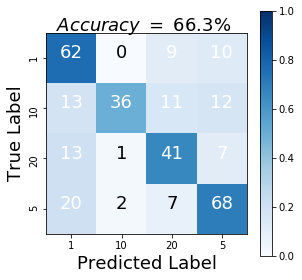

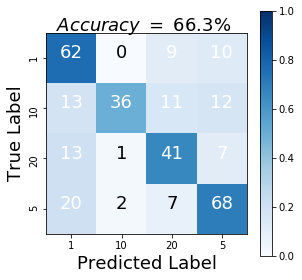

In [14]:
def plotConfusionMatrix(df, label, prediction, classLabels):
  from mmlspark.plot import confusionMatrix
  import matplotlib.pyplot as plt
  fig = plt.figure(figsize=(4.5, 4.5))
  confusionMatrix(df, label, prediction, classLabels)
  display(fig)

test = spark.read.parquet("test.parquet")
plotConfusionMatrix(fitModel.transform(test), "index", "prediction", fitModel.stages[0].stages[0].labels)

In [15]:
from __future__ import print_function
import os
from azureml.core.authentication import (
    AzureCliAuthentication, InteractiveLoginAuthentication,
    ServicePrincipalAuthentication, AuthenticationException)

def get_auth():
    """Get an auth object for use with Workspace objects."""
    if os.environ.get("AML_SP_PASSWORD", None):
        print("Trying to create Workspace with Service Principal")
        aml_sp_password = os.environ.get("AML_SP_PASSWORD")
        aml_sp_tenant_id = os.environ.get("AML_SP_TENANT_ID")
        aml_sp_username = os.environ.get("AML_SP_USERNAME")
        auth = ServicePrincipalAuthentication(
            tenant_id=aml_sp_tenant_id,
            service_principal_id=aml_sp_username,
            service_principal_password=aml_sp_password
        )
    else:
        print("Trying to create Workspace with CLI Authentication")
        try:
            auth = AzureCliAuthentication()
            auth.get_authentication_header()
        except AuthenticationException:
            print("Trying to create Workspace with Interactive login")
            auth = InteractiveLoginAuthentication()
    return auth

In [16]:
from azureml.core import Workspace
import azureml.core
print("azureml.core.VERSION=" + azureml.core.VERSION)

azureml.core.VERSION=1.0.33


In [17]:
auth = get_auth()
ws = Workspace.create(name='mmlspark',
                      subscription_id="edf507a2-6235-46c5-b560-fd463ba2e771",
                      resource_group="mmlspark",
                      create_resource_group=True,
                      exist_ok=True,
                      location='eastus2',
                      auth=auth)
ws.write_config()

Trying to create Workspace with CLI Authentication


Deploying StorageAccount with name mmlsparkstorageed45531bc.
Deploying AppInsights with name mmlsparkinsights13d1328c.
Deployed AppInsights with name mmlsparkinsights13d1328c.
Deploying KeyVault with name mmlsparkkeyvaultecd8e29a.
Deploying Workspace with name mmlspark.
Deployed KeyVault with name mmlsparkkeyvaultecd8e29a.
Deployed StorageAccount with name mmlsparkstorageed45531bc.
Deployed Workspace with name mmlspark.


In [20]:
print('SDK version: ', azureml.core.VERSION,
      'Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

SDK version: 
1.0.33
Workspace name: mmlspark
Azure region: eastus2
Subscription id: edf507a2-6235-46c5-b560-fd463ba2e771
Resource group: mmlspark


In [24]:
import os
from azureml.core.model import Model

model_name = "SeeingAIModel.mml"
model_path = model_name
fitModel.write().overwrite().save(model_name) 
amlmodel = Model.register(model_path = model_path, model_name = model_name, workspace = ws)
print(amlmodel.name, amlmodel.description, amlmodel.version)

Registering model SeeingAIModel.mml
SeeingAIModel.mml None 1


In [25]:
%%writefile score_sparkml.py
from time import sleep
from uuid import uuid4
from azureml.core.model import Model
from pyspark.ml import PipelineModel
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import requests, os, json
import base64

def init():
    spark = SparkSession.builder\
      .config("spark.jars.packages", "com.microsoft.ml.spark:mmlspark_2.11:0.16.dev20")\
      .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven")\
      .master("local[*]")\
      .appName("Model Server").getOrCreate()
    import mmlspark

    model_path = Model.get_model_path("SeeingAIModel.mml")
    model = PipelineModel.load(model_path)
    model.stages[0].stages[1].setMiniBatchSize(1) 
    
    server = (spark.readStream.continuousServer()
        .address("localhost", 8089, "predict")
        .option("path", "predict")
        .load()
        .parseRequest("predict", BinaryType())
        .withColumnRenamed("bytes", "image")
        .mlTransform(model)
        .makeReply("predictedLabels")
        .writeStream.continuousServer()
        .trigger(continuous="30 seconds")
        .replyTo("predict")
        .queryName("prediction")
        .option("checkpointLocation", os.path.join('/tmp', 'checkpoints', uuid4().hex))
        .start())
    sleep(1)

def run(input_json):
    try:
        image_url = json.loads(input_json)["url"]
        return requests.post(data=requests.get(image_url).content, url='http://localhost:8089/predict').json()
    except Exception as e:
        return {"error": str(e)}

Overwriting score_sparkml.py


In [26]:
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.image import ContainerImage

with open("myenv.yaml","w") as f:
    f.write(CondaDependencies.create(
      conda_packages=['requests', 'pyspark'],
      pip_packages=['azureml-core']).serialize_to_string())

image_config = ContainerImage.image_configuration(
  execution_script="score_sparkml.py", 
  runtime="python",
  conda_file="myenv.yaml",
  base_image="mhamilton723/pyspark:0.2")

# Webservice creation
service = Webservice.deploy_from_model(
  workspace=ws, 
  name="currencydetector",
  deployment_config = AciWebservice.deploy_configuration(cpu_cores = 2, memory_gb = 4),
  models = [amlmodel],
  image_config = image_config)

service.wait_for_deployment(show_output=True)

Creating image
Image creation operation finished for image currencydetector:1, operation "Succeeded"
Creating service
Running.........................................
SucceededACI service creation operation finished, operation "Succeeded"


In [ ]:
image_json =  """{"url":"https://mmlspark.blob.core.windows.net/graphics/SparkSummit2019/10dollarbill.jpg"}"""
resp = requests.post(url="http://{}:80/score".format(service.public_ip),
                     data=image_json,
                     headers={"Content-Type": "application/json"})
resp.text

In [ ]:
service.delete()